
# World Happiness Analysis

### Chen Xinyi, Dong Yunxing, Joseph Fung King Yiu
---

# Problem 3: Relations between changes in Happiness and changes in the 6 factors & some observations

## Import modules
---

In [1]:
# Basic Libraries
from __future__ import absolute_import, division, print_function
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set() 

import statsmodels.formula.api as stats
from statsmodels.formula.api import ols

# Import lib for Country converter
import country_converter as coco
import pycountry_convert as pypi
import plotly.plotly as py 
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


#Import Random Forest Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler




C:\Users\chenx\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



## Import Dataset
---

In [2]:
happinessData = pd.read_excel('data.xls')
print("Number of Countries :", len(happinessData["country"].unique()))
happinessData= happinessData.drop(['GINI index (World Bank estimate)','gini of household income reported in Gallup, by wp5-year','Positive affect','Negative affect','Confidence in national government','Democratic Quality','Delivery Quality','Standard deviation of ladder by country-year','Standard deviation/Mean of ladder by country-year','GINI index (World Bank estimate), average 2000-15'],axis=1)
happinessData=happinessData.dropna()

Number of Countries : 164


## 1. Data Preparation 

* Take only 6 factors: GDP, Social Support, Corruption, Life Expectancy, Freedom, Generosity,
* Calculate the average value of each variable in two periods: 2008-2010, 2015-2017
* Take the changes

In [3]:
# list of country names
country_list = list(set(list(happinessData["country"])))

df_by_countries = []


# a list of country dataframes, dropping country
for name in country_list:
    df = happinessData.loc[happinessData['country'] == name]
    df = df.drop(['country'], axis = 1)
    df_by_countries.append(df)


# a list of country dataframes containing changes in variables, should drop year

# for each variable in each country, try to find year 2008, 2009, 2010, and 2015, 2016, 2017
# and count the number of years: two counters and two sum variables (1<= counter <=3)
# average = sum/counter

df_by_countries_changes = []


for df in df_by_countries:
    for var in df:

        counter_1 = 0
        counter_2 = 0
        sum_1 = 0
        sum_2 = 0

        for i in range(len(df) - 1):
            #df.iloc[len(df) - 1 - i][var] -= df.iloc[len(df) - 2 - i][var]


            if df['year'].iloc[i]== 2008 or df['year'].iloc[i] == 2009 or df['year'].iloc[i] == 2010:
                sum_1 += df[var].iloc[i]
                counter_1 +=1

            elif df['year'].iloc[i] == 2015 or df['year'].iloc[i]== 2016 or df['year'].iloc[i] == 2017:
                sum_2 += df[var].iloc[i]
                counter_2 +=1

        if sum_1 == 0 or sum_2 == 0: #data points not available 
            average_1 = 0
            average_2 = 0
        else:
            average_1 = sum_1 / counter_1
            average_2 = sum_2 / counter_2

        change = average_2 - average_1
        df[var].iloc[0] = change

    df = df.drop(['year'], axis = 1)
    df = df[:1]

    df_by_countries_changes.append(df)

changes_data = pd.concat(df_by_countries_changes, ignore_index = False)

#remove rows with zero changes

changes_data_cleaned = changes_data.loc[changes_data['Life Ladder'] != 0]


C:\Users\chenx\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



## 2. Check correlation of  changes in variables and changes in life ladder 

In [4]:
changes_data_cleaned.corr()

,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption
Life Ladder,1.000000,0.205457,0.459628,-0.177305,0.359363,0.052078,-0.168984
Log GDP per capita,0.205457,1.000000,0.062383,0.147754,0.312774,0.057890,-0.064427
Social support,0.459628,0.062383,1.000000,-0.206010,0.205041,0.037329,-0.152881
Healthy life expectancy at birth,-0.177305,0.147754,-0.206010,1.000000,0.087580,0.091455,-0.135902
Freedom to make life choices,0.359363,0.312774,0.205041,0.087580,1.000000,0.245548,-0.355586
Generosity,0.052078,0.057890,0.037329,0.091455,0.245548,1.000000,-0.163640
Perceptions of corruption,-0.168984,-0.064427,-0.152881,-0.135902,-0.355586,-0.163640,1.000000


## 3. Use random forest regression to predict changes in happiness with changes in predictors 

Find the best combination of parameters and save the best model:

In [9]:
# Recall the PREDICTORS-LIFE LADDER Dataset
happiness = pd.DataFrame(changes_data_cleaned['Life Ladder'])   # Response
predictors = pd.DataFrame(changes_data_cleaned[['Log GDP per capita','Social support','Healthy life expectancy at birth','Freedom to make life choices','Perceptions of corruption']])         # Predictor
Max = 0
Best = []
#Data Normalization
ss = StandardScaler()
ss.fit_transform(predictors)
test_size =0.3
random_state = [10 + 5*x for x in range(9)]
n_estimators = [80 + 10*x for x in range(8)]
max_depth = [50 + 10*x for x in range(15)]
# Split the Dataset into Train and Test
for random_state1 in random_state:
    for n_estimators1 in n_estimators:
        for max_depth1 in max_depth:
            X_train, X_test, y_train, y_test = train_test_split(predictors, happiness, test_size = 0.3,random_state = random_state1) # predictor first than response

            #Create a Random Forest Regressor
            clf=RandomForestRegressor(n_estimators=n_estimators1,max_depth=max_depth1)

            #Train the model using the training sets y_pred=clf.predict(X_test)
            clf.fit(X_train,y_train)

            # Predict Life Ladder values corresponding to the 6 factors
            y_train_pred = clf.predict(X_train)
            y_test_pred = clf.predict(X_test)
            a = clf.score(X_test, y_test)
            if  a > Max:
                Max = a
                Best = [random_state1, n_estimators1, max_depth1]
                BestModel = clf
print(Max)
print(Best)

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning:

A c

0.42487114469832454
[25, 140, 80]


Use the best model to predict:

C:\Users\chenx\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.8781844495609336
Mean Squared Error (MSE) 	: 0.0306124704736153

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.409555870064128
Mean Squared Error (MSE) 	: 0.10171274891729187



Text(0, 0.5, 'Predicted values of the Response Variable [CHANGE IN LIFE LADDER] (Test)')

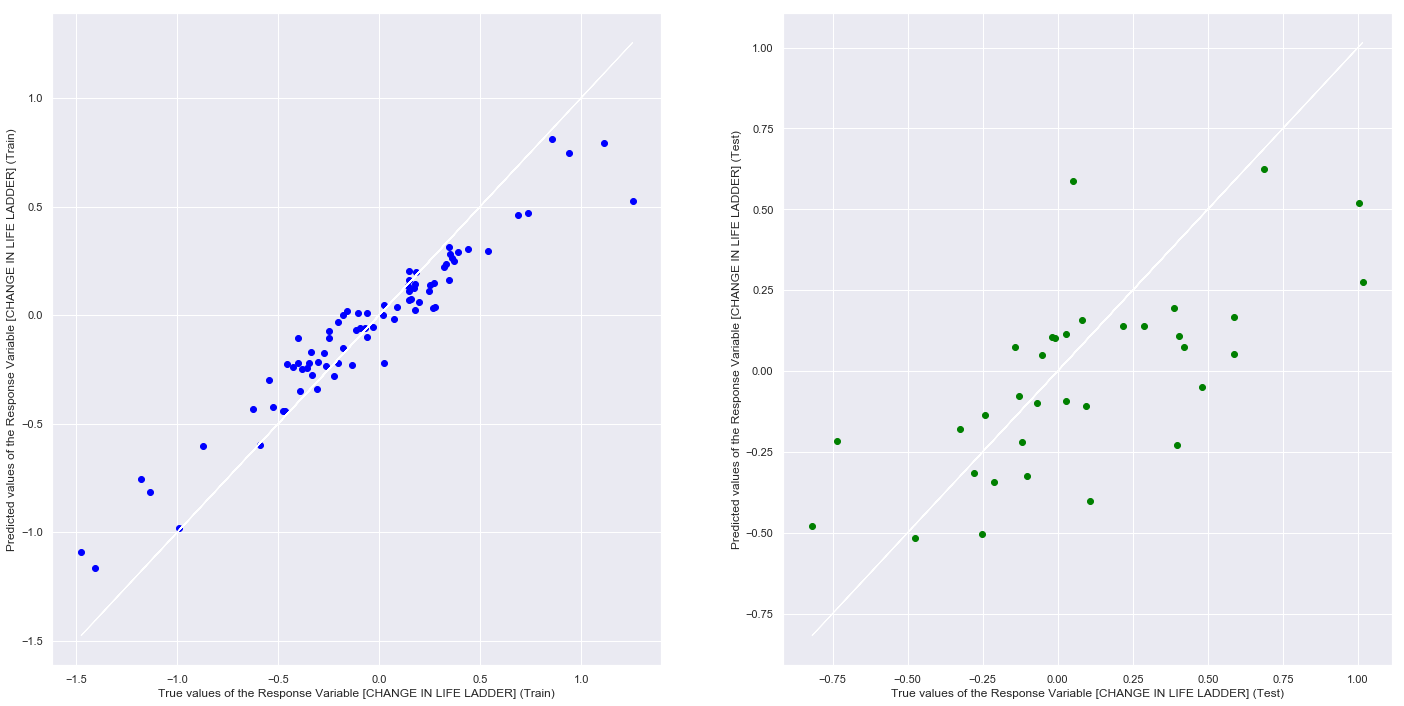

In [62]:
# Recall the PREDICTORS-LIFE LADDER Dataset
happiness = pd.DataFrame(changes_data_cleaned['Life Ladder'])   # Response
predictors = pd.DataFrame(changes_data_cleaned[['Log GDP per capita','Social support','Healthy life expectancy at birth','Freedom to make life choices','Perceptions of corruption']])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(predictors, happiness, test_size = 0.3,random_state = 25) # predictor first than response

#Create a Random Forest Regressor
clf=RandomForestRegressor(n_estimators=140,max_depth=80)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

# Predict Change in Life Ladder values corresponding to the 6 factors
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", clf.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", clf.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable [CHANGE IN LIFE LADDER] (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable [CHANGE IN LIFE LADDER] (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable [CHANGE IN LIFE LADDER] (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable [CHANGE IN LIFE LADDER] (Test)")


The R^2 value is 0.41 and the MSE is 0.1 